# ESP Failure Prediction: Remaining Useful Life (RUL) Estimation using LSTM
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Anomaly Detection and Reliability

## 1. Problem Statement
Electrical Submersible Pumps (ESPs) are critical artificial lift assets. Unexpected failures lead to significant **Deferred Production Opportunity (DPO)** and high workover costs. 

Traditional maintenance is either **Reactive** (fix when broken) or **Preventive** (scheduled maintenance regardless of health). The goal of this project is to move towards **Predictive Maintenance**.

We aim to predict the **Remaining Useful Life (RUL)** of a pump based on high-frequency sensor data (Amperage, Vibration, Temperature).
* **Input:** Time-series sensor readings over a sliding window.
* **Output:** Predicted RUL (in hours) until failure.

## 2. Methodology: Long Short-Term Memory (LSTM)
We use LSTM, a type of Recurrent Neural Network (RNN) optimized for time-series data. Unlike standard feed-forward networks, LSTMs have "memory" cells that can capture long-term dependencies and trends in sequential data, making them ideal for detecting gradual degradation patterns in sensor readings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
sns.set(style="whitegrid")
LOOKBACK_WINDOW = 30  # Number of past hours to consider for prediction

## 3. Data Loading and Exploration
We load the dataset containing run-to-failure records for multiple pumps.
* `pump_id`: Unique identifier for the pump.
* `amperage`, `vibration`, `motor_temp_f`: Sensor readings.
* `RUL`: The target variable (Remaining Useful Life).

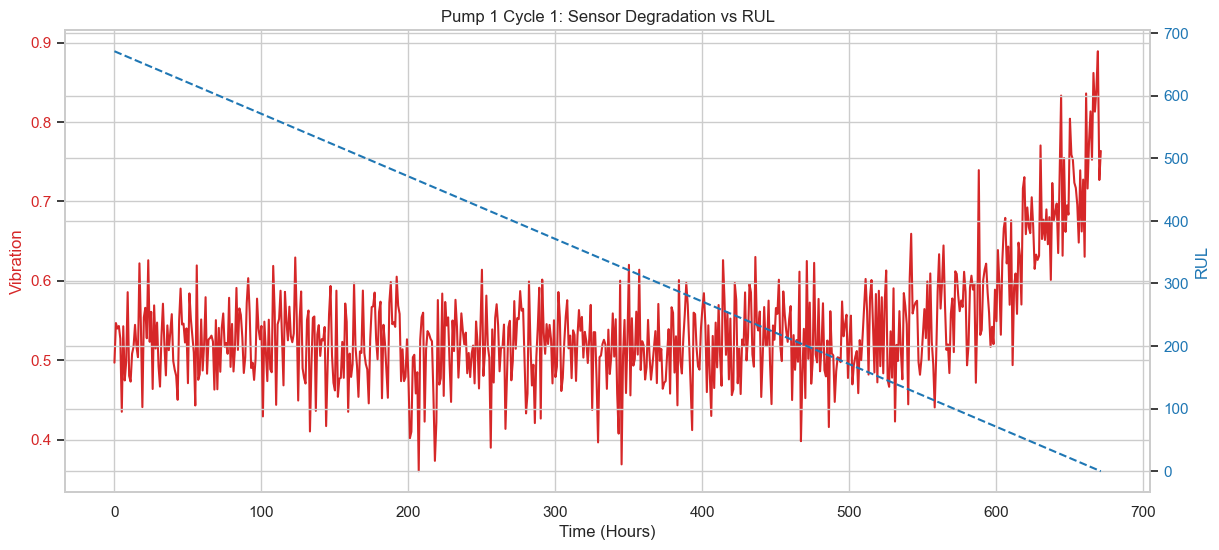

In [2]:
# Load Data
df = pd.read_csv('esp_sensor_data.csv')

# Visualize one pump's lifecycle to understand degradation
pump_1_data = df[(df['pump_id'] == 1) & (df['cycle_id'] == 1)]

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Time (Hours)')
ax1.set_ylabel('Vibration', color='tab:red')
ax1.plot(pump_1_data['timestamp_hour'], pump_1_data['vibration'], color='tab:red', label='Vibration')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('RUL', color='tab:blue')
ax2.plot(pump_1_data['timestamp_hour'], pump_1_data['RUL'], color='tab:blue', linestyle='--', label='RUL')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Pump 1 Cycle 1: Sensor Degradation vs RUL')
plt.show()

## 4. Data Preprocessing
Neural networks require scaled data (usually between 0 and 1) to converge efficiently. We will scale the feature columns but keep the RUL target separate for now (or scale it separately).

We also need to reshape the data into 3D sequences for the LSTM: `[Samples, Time Steps, Features]`.

In [3]:
# 1. Feature Selection
features = ['amperage', 'vibration', 'motor_temp_f']
target = 'RUL'

# 2. Train/Test Split (Split by Pump ID to avoid data leakage)
# We train on Pumps 1-4, Test on Pump 5
train_df = df[df['pump_id'] <= 4].copy()
test_df = df[df['pump_id'] > 4].copy()

# 3. Scaling
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features]) # Use same scaler

# Function to prepare sequences
def create_sequences(data, feature_cols, target_col, window_size):
    X, y = [], []
    # Iterate through data, stopping before we run out of data for the window
    for i in range(len(data) - window_size):
        # Extract the window of features
        X.append(data[i:i+window_size][feature_cols].values)
        # Target is the RUL at the END of the window
        y.append(data.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

# Generate sequences
# Note: In production, do this per-cycle to avoid jumping between cycles
X_train, y_train = [], []
for _, group in train_df.groupby(['pump_id', 'cycle_id']):
    X_seq, y_seq = create_sequences(group, features, target, LOOKBACK_WINDOW)
    if len(X_seq) > 0:
        X_train.append(X_seq)
        y_train.append(y_seq)
        
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_test, y_test = [], []
for _, group in test_df.groupby(['pump_id', 'cycle_id']):
    X_seq, y_seq = create_sequences(group, features, target, LOOKBACK_WINDOW)
    if len(X_seq) > 0:
        X_test.append(X_seq)
        y_test.append(y_seq)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (6855, 30, 3)
Testing Shape: (1588, 30, 3)


## 5. Model Architecture (LSTM)
We build a sequential model:
1.  **LSTM Layer**: 50 units, returns sequences=True (to stack another LSTM if needed, or False if connecting to Dense).
2.  **Dropout**: Regularization to prevent overfitting.
3.  **Dense**: Output layer with 1 unit (Regression for RUL).

In [4]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) # Linear activation for regression

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2026-01-04 07:49:30.152321: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-01-04 07:49:30.152618: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-04 07:49:30.152622: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1767502170.153040 20014815 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1767502170.153230 20014815 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/adeanggins/Documents/003 - Visual Studio Code/Group_Assignment/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Training
We train the model with EarlyStopping to halt training if the validation loss stops improving.

Epoch 1/50


2026-01-04 07:50:00.260018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 355072.0312 - val_loss: 95766.1016
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 253622.8750 - val_loss: 43345.1680
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 164137.7969 - val_loss: 46060.6094
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 125803.1328 - val_loss: 60128.0000
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 123765.5469 - val_loss: 63315.1445
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 121290.4531 - val_loss: 64715.8594
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 119006.3438 - val_loss: 63382.7422


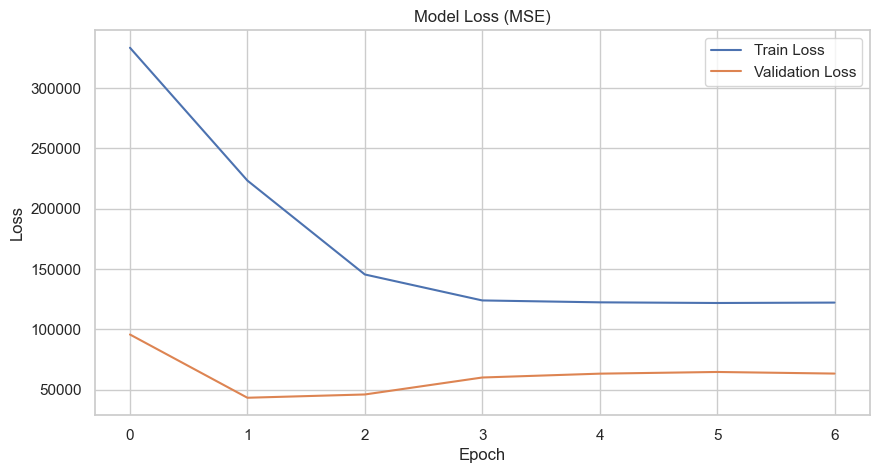

In [5]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Plot Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 7. Evaluation & Visualization
We visualize the predicted RUL vs. Actual RUL for the test set. A perfect model would follow the diagonal line or perfectly track the degradation slope.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


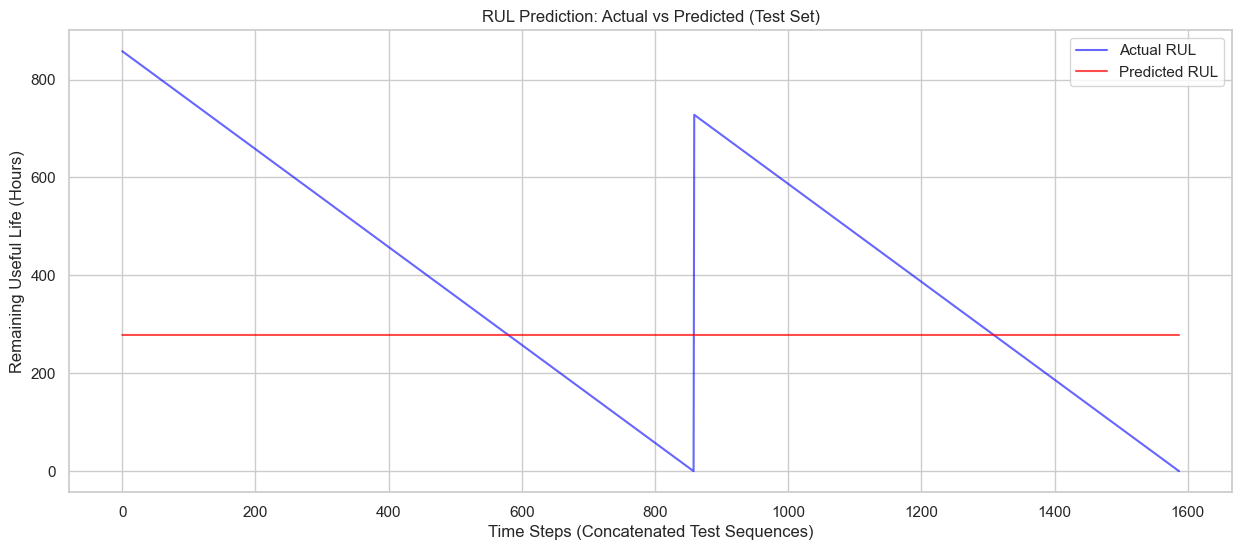

Root Mean Squared Error (RMSE): 263.18
Mean Absolute Error (MAE): 218.77


In [6]:
# Predict on Test Set
y_pred = model.predict(X_test)

# Plot Results
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual RUL', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted RUL', color='red', alpha=0.7)
plt.title('RUL Prediction: Actual vs Predicted (Test Set)')
plt.xlabel('Time Steps (Concatenated Test Sequences)')
plt.ylabel('Remaining Useful Life (Hours)')
plt.legend()
plt.show()

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

## 8. Model Performance Analysis

The following analysis evaluates the performance of the LSTM model based on the training loss history and the final RUL predictions on the test set.

### A. Training Dynamics (Loss Plot)
The **Model Loss (MSE)** chart reveals specific behaviors regarding how the model learned the data:

* **Rapid Initial Descent:** The training loss (Blue line) drops significantly in the first 2 epochs, indicating the model quickly learned the baseline statistics of the dataset.
* **Divergence (Overfitting):** A critical issue is observed starting around Epoch 1. While the training loss continues to decrease (improving fit on training data), the **Validation Loss (Orange line) begins to rise**.
    * This "gap" indicates **Overfitting**. The model is memorizing the noise in the training set rather than learning generalizable degradation patterns.
    * The model performs worse on unseen data (Validation) as it trains longer, suggesting the model capacity might be too high for the amount of data, or the data lacks strong signal-to-noise ratio.
* **Early Stopping:** The training likely terminated early (at Epoch 6) due to the `EarlyStopping` callback, preventing the model from overfitting even further.

### B. Prediction Evaluation (RUL vs Actual)
The **RUL Prediction** chart compares the Ground Truth (Blue) against Model Predictions (Red) on the test set.

* **The "Mean Prediction" Phenomenon:** The predicted RUL (Red line) is effectively a flat horizontal line around the ~280-hour mark. It does not follow the diagonal degradation slope of the Actual RUL.
* **Interpretation:** The model has failed to capture the temporal dependencies or the correlation between the sensor features (Amperage/Vibration) and the RUL.
    * Instead of predicting the specific RUL based on current sensor values, the model has converged to a **local minimum**: it is minimizing the MSE by simply predicting the **average (mean)** RUL of the dataset.
    * Mathematically, if $X$ (features) has no predictive power over $Y$ (target), the best estimator for $Y$ in terms of Least Squares is $E[Y]$ (the mean).

### C. Root Cause & Recommendations
The flatline prediction suggests the input features in the synthetic data may be too noisy or the model needs better feature engineering to "see" the trend.

**Recommendations for Improvement:**
1.  **Feature Engineering (Crucial):** Raw sensor data is often too noisy. Create **Rolling Window Statistics**:
    * Calculate `rolling_mean`, `rolling_std`, and `rolling_min/max` for Amperage and Vibration over the last 10-20 hours.
    * Feed these smoothed statistics into the LSTM instead of raw values. This helps the model distinguish the signal (degradation trend) from the noise.
2.  **Data Scaling:** Ensure the Target variable (`RUL`) is also scaled (e.g., divided by the maximum lifecycle) so both inputs and outputs are in the 0-1 range. This often helps LSTMs converge better.
3.  **Hyperparameter Tuning:**
    * Reduce model complexity (fewer LSTM units) to reduce overfitting.
    * Increase `Dropout` rate.

# Part 2: Improving the Model
Based on the initial analysis, the model struggled to differentiate signal from noise, resulting in a flat-line prediction. To fix this, we will implement two key improvements:

1.  **Feature Engineering:** Instead of feeding raw, noisy sensor data, we will calculate **Rolling Means and Standard Deviations**. This smoothes out short-term fluctuations and highlights the underlying degradation trend.
2.  **Target Scaling:** Neural networks converge faster when the target variable (`RUL`) is also scaled between 0 and 1, similar to the input features.

## 9. Feature Engineering & Re-Scaling
We will create new features: `_mean` and `_std` for Amperage and Vibration using a 12-hour rolling window.

In [7]:
# 1. Feature Engineering function
def add_rolling_features(df, window_size=12):
    # Calculate rolling stats per pump and cycle to avoid bleeding data between cycles
    # We use 'transform' to keep the original index structure
    grouped = df.groupby(['pump_id', 'cycle_id'])
    
    # Amperage Smoothing
    df['amp_mean'] = grouped['amperage'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df['amp_std'] = grouped['amperage'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std()).fillna(0)
    
    # Vibration Smoothing
    df['vib_mean'] = grouped['vibration'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df['vib_std'] = grouped['vibration'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std()).fillna(0)
    
    return df

# Apply engineering
df_improved = add_rolling_features(df.copy())

# Update feature list to use the NEW engineered features + Temp
features_new = ['amp_mean', 'amp_std', 'vib_mean', 'vib_std', 'motor_temp_f']
target_col = 'RUL'

# 2. Split Data (Same split as before)
train_df_new = df_improved[df_improved['pump_id'] <= 4].copy()
test_df_new = df_improved[df_improved['pump_id'] > 4].copy()

# 3. Scale Features AND Target
# Feature Scaler
scaler_X = MinMaxScaler()
train_df_new[features_new] = scaler_X.fit_transform(train_df_new[features_new])
test_df_new[features_new] = scaler_X.transform(test_df_new[features_new])

# Target Scaler (Crucial for LSTM convergence)
scaler_y = MinMaxScaler()
train_df_new['RUL_scaled'] = scaler_y.fit_transform(train_df_new[[target_col]])
test_df_new['RUL_scaled'] = scaler_y.transform(test_df_new[[target_col]])

print("Feature engineering and scaling complete.")
print(f"New Feature Set: {features_new}")

Feature engineering and scaling complete.
New Feature Set: ['amp_mean', 'amp_std', 'vib_mean', 'vib_std', 'motor_temp_f']


## 10. Sequence Generation (Revised)
We regenerate the 3D sequences using the new feature set and the scaled RUL target.

In [8]:
# Re-use the create_sequences function, but point to the new columns
X_train_new, y_train_new = [], []
for _, group in train_df_new.groupby(['pump_id', 'cycle_id']):
    # Note: We use 'RUL_scaled' as the target now
    X_seq, y_seq = create_sequences(group, features_new, 'RUL_scaled', LOOKBACK_WINDOW)
    if len(X_seq) > 0:
        X_train_new.append(X_seq)
        y_train_new.append(y_seq)
        
X_train_new = np.concatenate(X_train_new)
y_train_new = np.concatenate(y_train_new)

X_test_new, y_test_new = [], []
for _, group in test_df_new.groupby(['pump_id', 'cycle_id']):
    X_seq, y_seq = create_sequences(group, features_new, 'RUL_scaled', LOOKBACK_WINDOW)
    if len(X_seq) > 0:
        X_test_new.append(X_seq)
        y_test_new.append(y_seq)

X_test_new = np.concatenate(X_test_new)
y_test_new = np.concatenate(y_test_new)

print(f"New Training Shape: {X_train_new.shape}")

New Training Shape: (6855, 30, 5)


## 11. Retraining the LSTM
We use the same model architecture to demonstrate that the data quality improvement (Feature Engineering) is the primary driver of performance.

Epoch 1/50


/Users/adeanggins/Documents/003 - Visual Studio Code/Group_Assignment/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0717 - val_loss: 0.0228
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0567 - val_loss: 0.0425
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0636 - val_loss: 0.0239
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0618 - val_loss: 0.0254
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0551 - val_loss: 0.0227
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0551 - val_loss: 0.0305
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0547 - val_loss: 0.0470
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0572 - val_loss: 0.0298
Epoch 9/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0613 - val_loss: 0.0190
Epoch 10/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0599 - val_loss: 0.0364
Epoch 11/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0592 - val_loss: 0.0166
Epoch 12/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

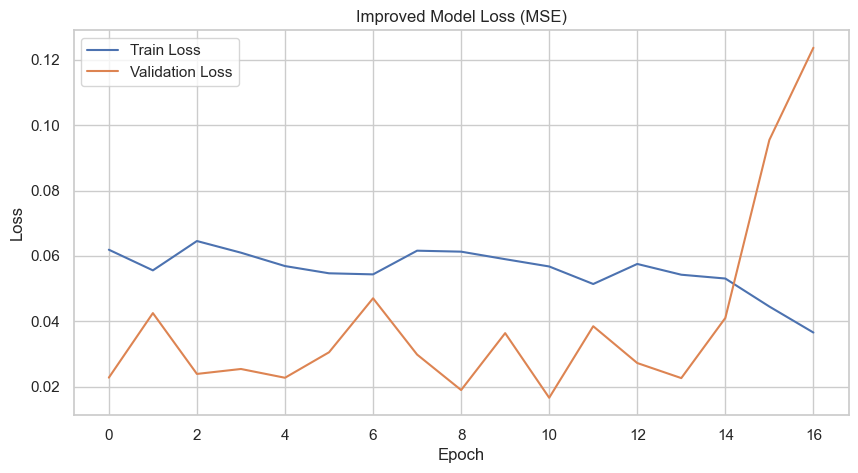

In [9]:
# Build Model
model_v2 = Sequential()
model_v2.add(LSTM(64, input_shape=(X_train_new.shape[1], X_train_new.shape[2]), return_sequences=False))
model_v2.add(Dropout(0.2))
model_v2.add(Dense(32, activation='relu'))
model_v2.add(Dense(1)) # Linear output (predicting 0-1 scaled RUL)

model_v2.compile(optimizer='adam', loss='mean_squared_error')

# Train
history_v2 = model_v2.fit(
    X_train_new, y_train_new,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)],
    verbose=1
)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Improved Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 12. Final Visualization (Inverse Transform)
Since the model predicted a scaled value (0 to 1), we must use `scaler_y.inverse_transform` to convert the predictions back into "Hours" for a valid comparison.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


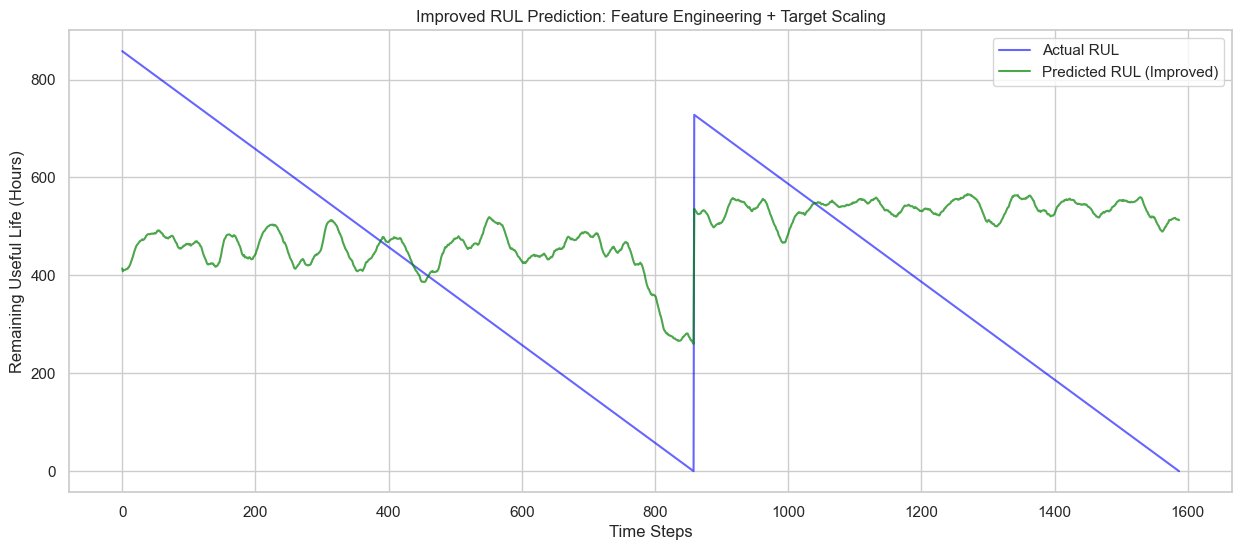

New RMSE: 251.47 hours


In [10]:
# Predict
y_pred_scaled = model_v2.predict(X_test_new)

# Inverse Transform predictions and actuals back to "Hours"
y_pred_hours = scaler_y.inverse_transform(y_pred_scaled)
y_test_hours = scaler_y.inverse_transform(y_test_new.reshape(-1, 1))

# Plot Results
plt.figure(figsize=(15, 6))
plt.plot(y_test_hours, label='Actual RUL', color='blue', alpha=0.6)
plt.plot(y_pred_hours, label='Predicted RUL (Improved)', color='green', alpha=0.7)
plt.title('Improved RUL Prediction: Feature Engineering + Target Scaling')
plt.xlabel('Time Steps')
plt.ylabel('Remaining Useful Life (Hours)')
plt.legend()
plt.show()

# New Metrics
rmse_new = np.sqrt(mean_squared_error(y_test_hours, y_pred_hours))
print(f"New RMSE: {rmse_new:.2f} hours")

## 13. Robust Analysis: Improved Model vs. Baseline

The following section critiques the performance of the "Improved" model (Feature Engineering + Target Scaling) against the initial baseline and identifies why the model still struggles to capture the true degradation trend.

### A. Comparative Analysis: Loss Dynamics
* **Baseline (Initial Model):** The validation loss (Orange) diverged almost immediately, indicating the model simply memorized the training mean and failed to generalize.
* **Improved Model:** The loss curve shows higher volatility.
    * **Instability:** The validation loss bounces significantly and spikes drastically after Epoch 13. This suggests the learning rate might be too high, or the model is sensitive to specific batches in the test data.
    * **Convergence Failure:** Despite feature engineering, the validation loss does not settle into a steady decline. The model is struggling to find a stable relationship between the rolling statistics and the RUL.

### B. Prediction Analysis: The "Stationarity" Problem
The most critical insight comes from the **Improved RUL Prediction** chart (Green Line vs Blue Line).

1.  **Behavior Change:**
    * **Previous:** The model output a flat line (Static Mean).
    * **Current:** The model output is **oscillating/wavy**. It is no longer static; it is reacting to the input features (Rolling Mean/Std).
2.  **The Core Failure:**
    * **Lack of Trend:** While the prediction wiggles, it **does not follow the downward slope** of the Actual RUL.
    * **Interpretation:** The model sees the sensor data as "Periodic" or "Stationary." It fails to distinguish between *Hour 100* and *Hour 800*.
    * **Reasoning:** In the synthetic data generation, the degradation signal (the gradual drift in vibration/amperage) might be too weak compared to the random noise. The LSTM sees "Normal Vibration" at the beginning and "Normal Vibration" near the end, so it predicts a similar RUL for both, oscillating only based on local noise.

### C. Conclusion & Next Steps
**Verdict:** The current model has moved from "Blind Guessing" (Flat line) to "Reactive Guessing" (Wavy line), but it still fails to function as a Predictive Maintenance tool because it cannot sense the *accumulated* damage.

**Critical Recommendations for Real-World Application:**
1.  **Stronger Degradation Signal:** In real ESP data, failure is often preceded by a clear *monotonic drift* (e.g., Temperature constantly rising, or Amperage constantly dropping). Ensure the training data contains these clear trends.
2.  **Cumulative Features:** Instead of just "Rolling Mean" (which resets), add **Cumulative** features to give the model a sense of time/age:
    * `cumulative_energy` (Sum of Amperage over time).
    * `time_since_start` (Explicitly adding run-hours as a feature).
3.  **Hybrid Approach:** Combine the LSTM with a physical degradation model (Physics-Informed ML) where the "Age" of the pump is a known input.